In [1]:
from visualization import cuGraph
from config import DATA_DIR

KN = cuGraph(outdir=DATA_DIR, graph_type='chunk', verbose=1)

/home/achraf/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Graph loaded from data//knowledge_graph/chunk_knowledge_graph.json


In [2]:
KN.pagerank()

/home/achraf/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cugraph/link_analysis/pagerank.py:232: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


,pagerank,vertex
3760,0.002452,Monkey_D._Luffy_2_1
3761,0.002248,Monkey_D._Luffy_1_1
3775,0.002035,Monkey_D._Luffy_4_0
3763,0.001558,Straw_Hat_Pirates_5_0
3762,0.001144,Sanji_4_0
...,...,...
29655,0.000005,Misery_2_0
30648,0.000005,Hyouzou_16_0
29050,0.000005,Enishida_7_0
30342,0.000005,Trafalgar_D._Water_Law/Misc._8_0


In [3]:
KN.betweenness_centrality()

,betweenness_centrality,vertex
3680,0.062008,Monkey_D._Luffy_2_1
3681,0.037832,Monkey_D._Luffy_1_1
3695,0.031121,Monkey_D._Luffy_4_0
3683,0.019975,Straw_Hat_Pirates_5_0
3687,0.018995,Charlotte_Linlin_1_0
...,...,...
31028,0.000000,Sheepshead_19_0
31029,0.000000,Woop_Slap_29_0
31030,0.000000,Bunbuku_4_0
31031,0.000000,Jango_35_0


In [4]:
KN.edge_betweenness_centrality()

,src,dst,betweenness_centrality
934761,Polearm_2_0,Smooge_8_0,0.004034
48590,%C3%89poni_1_0,Cosette_11_0,0.003938
163632,Damask_3_0,Weapons_22_0,0.003938
640766,Bartholomew_Kuma_6_0,Lindbergh_20_0,0.003938
1199342,Jango_38_0,Monkey_D._Luffy/Relationships_2_1,0.003938
...,...,...,...
1162712,Hiroshi_5_0,Wakasa_4_0,0.000000
1165771,Scales_6_0,Underbite_7_0,0.000000
1182464,Dirt_Boss_2_0,Forest_Boss_5_0,0.000000
1187217,Kisegawa_5_0,Tokijiro_5_0,0.000000


In [5]:
KN.detect_communities()

In [6]:
KN.edges_df

,src,dst,label,weight,betweenness_centrality
0,Absalom_1_0,Hogback_1_0,Hogback,0.692626,1.883296e-07
1,Absalom_1_0,Hogback_13_0,Hogback,0.671126,2.490207e-07
2,Absalom_1_0,Hogback_29_0,Hogback,0.631624,8.298807e-07
3,Absalom_2_0,Nico_Robin_3_0,Nico Robin,0.490781,6.947937e-06
4,Absalom_2_0,Nico_Robin_4_0,Nico Robin,0.488601,5.856381e-06
...,...,...,...,...,...
1230093,Zombie_48_0,Brook_4_0,Brook,0.596333,0.000000e+00
1230094,Zombie_44_0,Impel_Down_38_0,Impel Down,0.554501,0.000000e+00
1230095,Zombie_45_0,Mohji_18_0,Mohji,0.545359,0.000000e+00
1230096,Zombie_45_0,Mohji_17_0,Mohji,0.544789,0.000000e+00


In [7]:
KN.nodes_df

,node,pagerank,betweenness_centrality,partition
0,CP0_2_0,0.000045,4.654041e-05,4
1,CP0_3_0,0.000092,3.862501e-04,0
2,CP0_4_0,0.000090,3.799384e-04,0
3,CP0_5_0,0.000088,3.993285e-04,0
4,CP0_6_0,0.000132,4.924735e-04,0
...,...,...,...,...
31028,Trafalgar_D._Water_Law/History/During_and_Afte...,0.000014,2.854585e-07,6
31029,Seto_3_0,0.000006,0.000000e+00,9
31030,Holy_4_0,0.000006,0.000000e+00,9
31031,Columbus_9_0,0.000006,0.000000e+00,5


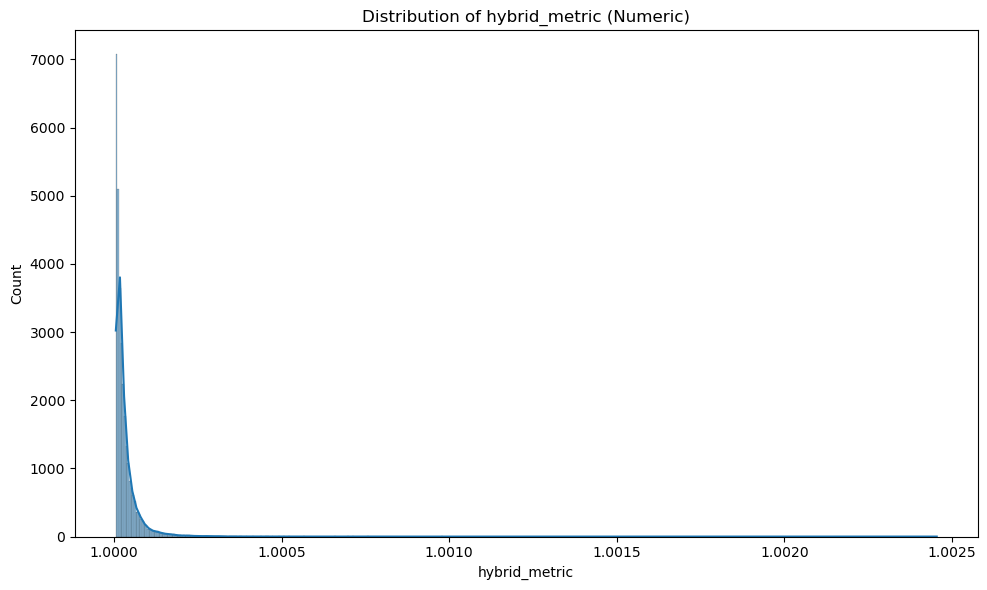

In [8]:
import numpy as np
def hybrid_score(pagerank): return np.exp(pagerank)
KN.plot_node_attribute_distribution(hybrid_attrs=['pagerank'], hybrid_func= hybrid_score, bins=500)

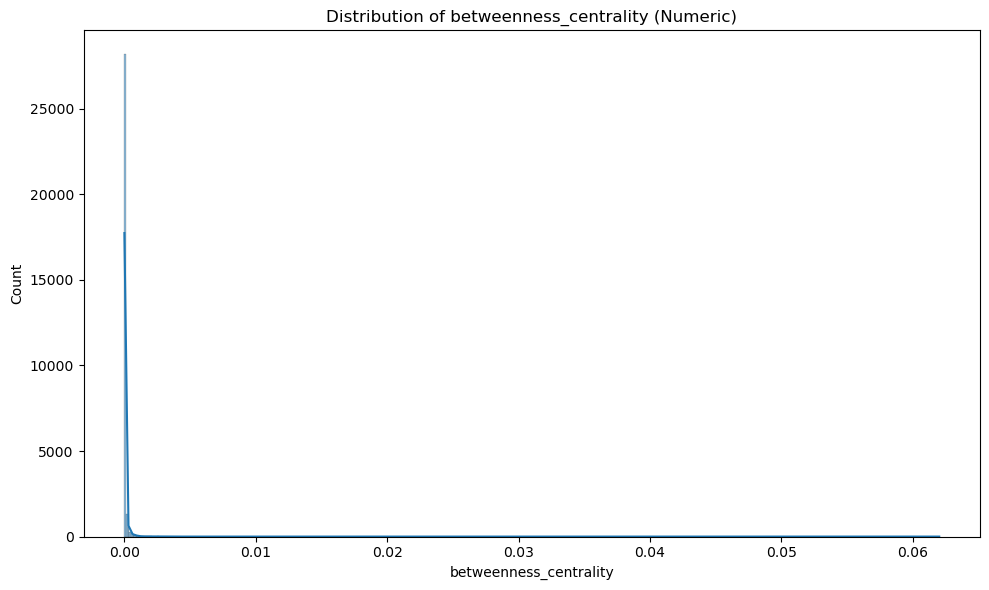

In [9]:
KN.plot_node_attribute_distribution('betweenness_centrality', bins=500)

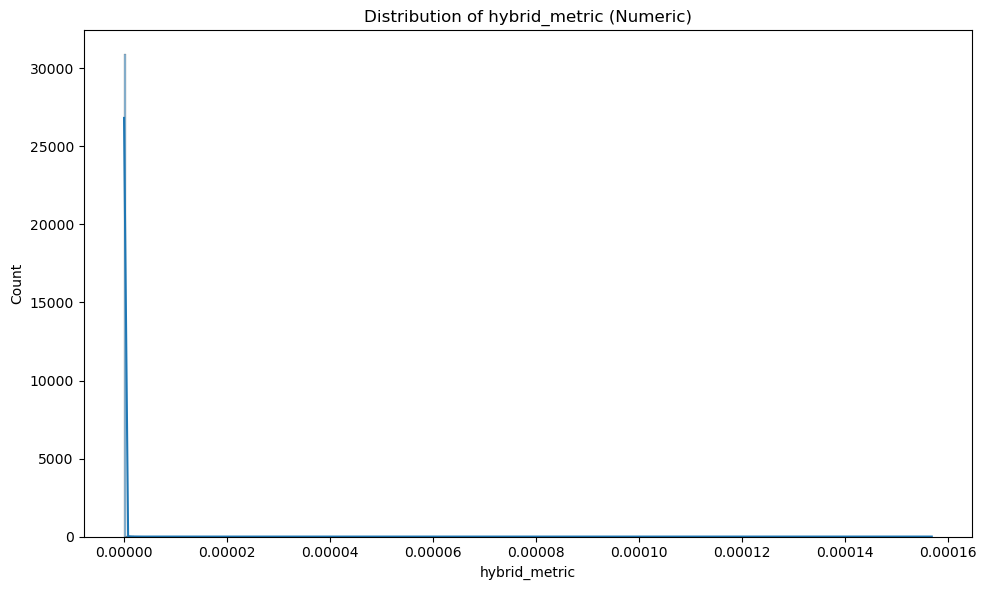

In [10]:
def hybrid_score(pagerank, bc): return pagerank * np.expm1(bc)
KN.plot_node_attribute_distribution(hybrid_attrs=['pagerank', 'betweenness_centrality'], hybrid_func= hybrid_score, bins=500)

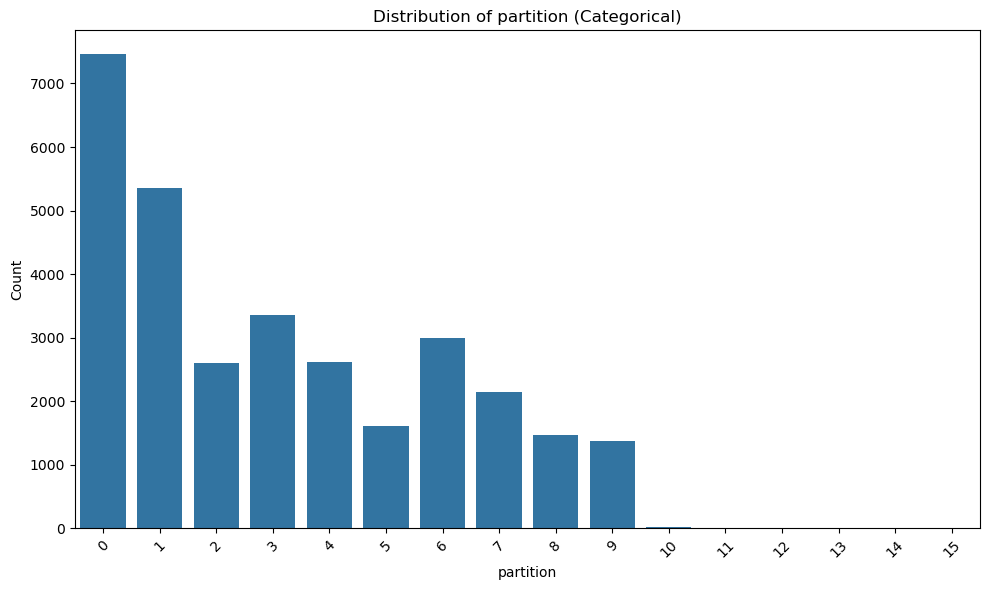

In [11]:
KN.plot_node_attribute_distribution(attr='partition')

In [12]:
# Top 90% PageRank nodes
top_nodes = KN.filter_nodes(by="pagerank", top_pct=0.9)

In [13]:
# Use a hybrid metric
def hybrid_score(pagerank, bc): return pagerank * bc
KN.filter_nodes(hybrid_attrs=['pagerank', 'betweenness_centrality'], hybrid_func= hybrid_score , top_pct=0.9, inplace=True)


,node,pagerank,betweenness_centrality,partition,hybrid_metric
25135,Giolla_16_0,0.000008,1.469408e-07,5,1.222924e-12
25134,Iyan%27eno_Chinode_6_0,0.000011,1.131208e-07,4,1.223197e-12
25130,Fullbody_37_0,0.000010,1.220610e-07,1,1.224721e-12
25131,Fullbody_38_0,0.000010,1.220610e-07,1,1.224721e-12
25132,Ironfist_37_0,0.000010,1.220610e-07,1,1.224721e-12
...,...,...,...,...,...
4,Charlotte_Linlin_1_0,0.000969,1.899497e-02,3,1.841031e-05
3,Straw_Hat_Pirates_5_0,0.001558,1.997493e-02,3,3.111959e-05
2,Monkey_D._Luffy_4_0,0.002035,3.112147e-02,3,6.332930e-05
1,Monkey_D._Luffy_1_1,0.002248,3.783232e-02,3,8.502917e-05


In [14]:
# Top 80% Edge Centrality nodes
top_nodes = KN.filter_edges(by="betweenness_centrality", top_pct=0.8)

In [15]:
KN.remove_dead_ends_and_orphans(recurse=True, inplace=True)

Removed 442911 edges...
Removed 50058 edges...
Removed 18478 edges...
Removed 16085 edges...
Removed 11234 edges...
Removed 7955 edges...
Removed 7719 edges...
Removed 7117 edges...
Removed 5733 edges...
Removed 1602 edges...
Removed 1347 edges...
Removed 144 edges...
Removed 40 edges...
Removed 63 edges...
Total edges removed: 570486


In [16]:
KN.edges_df

,src,dst,label,weight,betweenness_centrality
0,Charlotte_Anana_9_0,Charlotte_Linlin_1_0,Charlotte Linlin,0.519274,0.002386
1,Charlotte_Anana_7_0,Charlotte_Linlin_1_0,Charlotte Linlin,0.549640,0.001977
2,Foods_123_0,Jinbe_1_0,Jinbe,0.348299,0.001299
3,Charlotte_Cabaletta_13_0,Charlotte_Opera_23_0,Opera,0.790764,0.001237
4,Charlotte_Cabaletta_13_0,Charlotte_Opera_2_0,Opera,0.609670,0.001207
...,...,...,...,...,...
384796,Sakazuki_40_0,Revolutionary_Army_11_0,Revolutionary Army,0.432480,0.000000
384797,Sakazuki_40_0,Nefertari_Cobra_7_0,Cobra,0.605023,0.000000
384798,Sakazuki_40_0,Nefertari_Cobra_3_0,Cobra,0.407862,0.000000
384799,Sakazuki_40_0,Nefertari_Vivi_4_0,Vivi,0.503623,0.000000


In [17]:
KN.nodes_df

,node,pagerank,betweenness_centrality,partition,hybrid_metric
0,Monkey_D._Luffy_2_1,0.002452,6.200751e-02,3,1.520164e-04
1,Monkey_D._Luffy_1_1,0.002248,3.783232e-02,3,8.502917e-05
2,Monkey_D._Luffy_4_0,0.002035,3.112147e-02,3,6.332930e-05
3,Charlotte_Linlin_1_0,0.000969,1.899497e-02,3,1.841031e-05
4,Roronoa_Zoro_2_0,0.001041,1.702804e-02,0,1.772013e-05
...,...,...,...,...,...
12441,Hitsugisukan_2_0,0.000010,1.239215e-07,6,1.251232e-12
12442,Joy_Boy_11_0,0.000009,1.342233e-07,4,1.245090e-12
12443,Charlotte_Nusstorte_12_0,0.000009,1.351390e-07,3,1.228728e-12
12444,Bastille_14_0,0.000007,1.657914e-07,7,1.227269e-12


In [18]:
import graphistry
from graphistry.plugins.igraph import layout_algs as igraph_layouts
from graphistry.plugins.cugraph import layout_algs as cugraph_layouts

graphistry.register( 
        api=3,
        personal_key_id="35ODTI9CO5",
        personal_key_secret="2JHUSJENWLQO1KVE"
    )

# Normalize edge betweenness to a [0,1] range for transparency
ebc_min = KN.edges_df['betweenness_centrality'].min()
ebc_max = KN.edges_df['betweenness_centrality'].max()
KN.edges_df['edge_transparency'] = 1.0 - (KN.edges_df['betweenness_centrality'] - ebc_min) / (ebc_max - ebc_min + 1e-9)

# Normalize pagerank for size (optional step if values are very small)
pr_min = KN.nodes_df['pagerank'].min()
pr_max = KN.nodes_df['pagerank'].max()
KN.nodes_df['node_size'] = 10 + 90 * (KN.nodes_df['pagerank'] - pr_min) / (pr_max - pr_min + 1e-9)  # Size in range [10, 100]

{
    'igraph_layout_algs': ', '.join(igraph_layouts),
    'cugraph_layout_algs': ', '.join(cugraph_layouts)
}

# Build graph
#.modularity_weighted_layout('partition')
g = graphistry.edges(KN.edges_df, 'src', 'dst') \
             .bind(edge_title='label') \
             .bind(edge_opacity='edge_transparency') \
             .nodes(KN.nodes_df, 'node') \
             .bind(point_color='partition') \
             .bind(point_weight='node_size') \
             .bind(point_title='node') \
             .group_in_a_box_layout(
                partition_key='partition',
                layout_alg='force_atlas2',
                layout_params={
                    'lin_log_mode': True
                }
            )
            

# Launch the visualization
g.plot()

/home/achraf/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cugraph/structure/symmetrize.py:260: FutureWarning: This method is deprecated and will no longer be supported. The symmetrization of the edges are only supported by setting the 'symmetrize' flag to 'True'
  warnings.warn(
/home/achraf/miniconda3/envs/rapids-25.04/lib/python3.12/site-packages/cugraph/structure/symmetrize.py:92: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(
